In [ ]:
#Import libraries:

import json
import pandas as pd
import numpy as np
import codecs

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk import word_tokenize as tokenize
from nltk import pos_tag as tag
nltk.download('wordnet')

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline,manifold, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import gensim
import gensim.downloader as gensim_api
from spacy.lang.en.stop_words import STOP_WORDS as en_stop


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Device available for running: 
cuda


In [ ]:
!pip install datefinder
!pip install sutime
!pip install dateparser

In [ ]:
import dateparser
import datefinder
import datetime


import sutime
from sutime import SUTime
import json


Load and Pre-process data & Create Data loaders

In [ ]:
#mount google drive
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Enron/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#import and shuffle dataset

filepath = "/content/gdrive/MyDrive/Enron/data.csv"
# Read the data into a pandas dataframe called emails

emails = pd.read_csv(filepath)
emails = emails.sample(frac=1)

In [ ]:
# #word_vectors  = gensim_api.load("glove-wiki-gigaword-50")
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip


In [ ]:
#emails[emails['Message-Body'].duplicated() == True]#.sum()

In [ ]:
#Find duplicate text:
print('Number of duplicated in dataset:')
emails['Message-Body'].duplicated().sum()

Number of duplicated in dataset:


308

In [ ]:
#remove duplicate test
print('Removing duplicates..')
emails = emails.drop_duplicates(subset=['Message-Body'], keep='last')

Removing duplicates..


In [ ]:
print('Duplicates left:', emails['Message-Body'].duplicated().sum())


Duplicates left: 0


In [ ]:
################################################################################
#When this is true we do train val test split.
#Otherwise just train, val
test_on = True
################################################################################

In [ ]:
#split dataset
if test_on:
  X_train, x_test, Y_train, y_test = train_test_split(emails['Message-Body'], emails['class'], test_size = 0.1, random_state = 1)
  x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 1)
else:
  x_train, x_val, y_train, y_val = train_test_split(emails['Message-Body'], emails['class'], test_size = 0.1, random_state = 1)

In [ ]:
#create sub-dataframes
train_df = pd.concat([x_train, y_train], axis=1)
val_df = test_df = pd.concat([x_val, y_val], axis=1)
if test_on:
  test_df = pd.concat([x_test, y_test], axis=1)

In [ ]:
print('Checking for overlaps between datasets')
print()
commondf_1=pd.merge(x_train,x_val, on=['Message-Body'], right_index=True)
print('Common elements between train and val:', commondf_1.shape[0])
print()

if test_on:

  commondf_2=pd.merge(x_train,x_test, on=['Message-Body'], right_index=True)
  print('Common elements between train and test:', commondf_2.shape[0])
  print()
  commondf_3=pd.merge(x_val,x_test, on=['Message-Body'], right_index=True)
  print('Common elements between val and test:', commondf_3.shape[0])
  print()

  if commondf_2.shape[0] == commondf_3.shape[0] == commondf_1.shape[0] == 0:
    print('Correct! No overlap between sets')
  else:
    print('There is overlap between the sets')

Checking for overlaps between datasets

Common elements between train and val: 0

Common elements between train and test: 0

Common elements between val and test: 0

Correct! No overlap between sets


In [ ]:
#Check if split is even:

print('Meeting relevant emails in training data:')
print(train_df[train_df['class'] == 0].shape[0])
print(100*'-')
print('Other emails in training data:')
print(train_df[train_df['class'] == 1].shape[0])
print(100*'-')
print('Meeting relevant emails in validationN data:')
print(val_df[val_df['class'] == 0].shape[0])
print(100*'-')
print('Other emails in validation data:')
print(val_df[val_df['class'] == 1].shape[0])
print(100*'-')

if test_on:
  
  print('Meeting relevant emails in test data:')
  print(test_df[test_df['class'] == 0].shape[0])
  print(100*'-')
  print('Other emails in test data:')
  print(test_df[test_df['class'] == 1].shape[0])
  print(100*'-')

Meeting relevant emails in training data:
2727
----------------------------------------------------------------------------------------------------
Other emails in training data:
3144
----------------------------------------------------------------------------------------------------
Meeting relevant emails in validationN data:
324
----------------------------------------------------------------------------------------------------
Other emails in validation data:
329
----------------------------------------------------------------------------------------------------
Meeting relevant emails in test data:
330
----------------------------------------------------------------------------------------------------
Other emails in test data:
395
----------------------------------------------------------------------------------------------------


In [ ]:
#Preprocess messages:

def process_text(text, stemming=False, lemmatization=True, additional_stopwords = []):
    unwanted_seqs = ['calendar entry appointment description tms weekly',
                     'calendar entry appointment description team leader ',
                     'calendar entry appointment description',
                     'calendar entry appointment team leader',
                     'calendar entry appointment',
                     'chairperson outlook migration team detailed',
                     'inline attachment follows'
                     ]
    stemmer = nltk.stem.porter.PorterStemmer()
    lemmer = nltk.stem.wordnet.WordNetLemmatizer()


    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d{9,}', '', str(text).lower().strip())
    text = re.sub(r"http\S+","URL", str(text).lower().strip())

            
    ## Tokenize (convert from string to list)
    text_list = text.split()
    
    ## remove Stopwords
    stopwords = list(en_stop) + additional_stopwords
    text_list = [word for word in text_list if word not in stopwords]
                
    if stemming:
      lst_text = [stemmer.stem(word) for word in text_list]
                
    ## Lemmatisation (convert the word into root word)
    if lemmatization:
      lst_text = [lemmer.lemmatize(word) for word in text_list]
    
    ## back to string from list
    output = " ".join(text_list)

    for seq in unwanted_seqs:
      if seq in output:
        output = re.sub(seq, '', str(output).lower().strip())
    
    return output

In [ ]:
employee_list = emails.employee.unique().tolist()
my_words = ['enron', 'corp', 'hou', 'description'] + employee_list
print('Please wait. Preprocessing data...')

emails["text"] = emails["Message-Body"].apply(lambda x: process_text(x, False, True, my_words ))
train_df["text"] = train_df["Message-Body"].apply(lambda x: process_text(x, False, True, my_words ))
val_df["text"] = val_df["Message-Body"].apply(lambda x: process_text(x, False, True, my_words ))
if test_on:
  test_df["text"] = test_df["Message-Body"].apply(lambda x: process_text(x, False, True, my_words ))

print('preprocessing done!')

Please wait. Preprocessing data...
preprocessing done!


In [ ]:
sum_char_message_train = 0
sum_char_other_train = 0
sum_word_message_train = 0
sum_word_other_train = 0

for index, row in train_df.iterrows():
  char = len(row['text'])
  word = len(row['text'].split())
  if row['class'] == 0:
    sum_char_message_train += char
    sum_word_message_train += word
  else:
    sum_char_other_train += char
    sum_word_other_train += word

count_msg = train_df[train_df['class'] == 0].shape[0]
count_other = train_df[train_df['class'] == 1].shape[0]

avg_word_msg = sum_word_message_train/count_msg
avg_char_msg = sum_char_message_train/count_msg

avg_word_other = sum_word_other_train/count_other
avg_char_other = sum_char_other_train/count_other





In [ ]:
print('Average character count in meeting messages:', avg_char_msg)
print('Average word count in meeting messages:', avg_word_msg)
print('Average character count in other messages:', avg_char_other)
print('Average word count count in other messages:', avg_word_other)

Average character count in meeting messages: 119.33810047671435
Average word count in meeting messages: 17.77777777777778
Average character count in other messages: 1015.5480279898219
Average word count count in other messages: 135.7662213740458


In [ ]:
#Study the effects of preprocessing:
from random import sample
def print_before_after(df):
  rindex =  np.array(sample(range(len(df)), 1))
  idx = 10
  print(100*'-')
  print('ORIGINAL')
  print(100*'-')
  print(df["Message-Body"].iloc[rindex])
  print(100*'-')
  print(100*'-')
  print()
  print(100*'-')
  print('PROCESSED')
  print(100*'-')
  print(df["text"].iloc[rindex])
  print(100*'-')
  print(100*'-')

In [ ]:
print_before_after(emails)

----------------------------------------------------------------------------------------------------
ORIGINAL
----------------------------------------------------------------------------------------------------
6035    for your reference, please find attached a sho...
Name: Message-Body, dtype: object
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
PROCESSED
----------------------------------------------------------------------------------------------------
6035    reference find attached short presentation pre...
Name: text, dtype: object
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

In [ ]:
#Drop irrelevant column

train_df.drop(columns=['Message-Body'], inplace=True)
val_df.drop(columns=['Message-Body'], inplace=True)
if test_on:
  test_df.drop(columns=['Message-Body'], inplace=True)

In [ ]:
#Rename columns:

train_df.rename(columns={'class':'target'}, inplace=True)
val_df.rename(columns={'class':'target'}, inplace=True)
if test_on:
  test_df.rename(columns={'class':'target'}, inplace=True)

In [ ]:
train_df = train_df.drop(train_df[train_df['text'] == ''].index)
val_df = val_df.drop(val_df[val_df['text'] == ''].index)
if test_on:
  test_df = test_df.drop(test_df[test_df['text'] == ''].index)

In [ ]:
#use spacy to tokenize text. We will then use these to convert into tensors
message_field = data.Field(tokenize = 'spacy', include_lengths = True, batch_first= True)
label_field = data.LabelField(dtype = torch.float, batch_first = True)

In [ ]:
#This class will help use the Pandas emails dataframe as a data source.
#It can be found at:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8

class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields,**kwargs):#, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target #if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    #returns train val test datasets composed of the tokenized text and correpsonding labels
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field,**kwargs)# True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
#create the fields with the corresponding names
fields = [('text',message_field), ('label',label_field)]

#split up the datasets
print('Creating data structures. This will take a while...')
if test_on:
  training, validation,test = DataFrameDataset.splits(fields, train_df, val_df,test_df)
else:
  training, validation = DataFrameDataset.splits(fields, train_df, val_df)
  
print('Data structures created successfully!')

Creating data structures. This will take a while...
Data structures created successfully!


In [ ]:
#build a vocabulary using the training data. Max size is 30000, use glove 100d embeddings
#Also create an unknown token for words not in the vocab

print('Building vocabulary. Please wait...')
message_field.build_vocab(training, max_size = 30000, vectors = 'glove.6B.100d',
                 unk_init = torch.Tensor.zero_)

Building vocabulary. Please wait...


In [ ]:
#Save vocabulary for inference
# vocab_obj = message_field.vocab
# torch.save(vocab_obj, '/content/gdrive/MyDrive/Enron/vocab_obj.pth')

In [ ]:
label_field.build_vocab(training)

In [ ]:
glove_embeddings = message_field.vocab.vectors

In [ ]:
glove_dim = len(glove_embeddings[0])

In [ ]:
################################################################################
#Notes:
#Model tends to overfit with no dropout
#Better performance with dropout less than 0.5 and many epochs
#So use 2 layers and dropout after each fc
################################################################################

num_epochs = 20
batch_size = 64
learning_rate = 0.001
vocab_size = len(message_field.vocab)

#embedding dimension
embedding_dim = glove_dim
hidden_dim = 128
out_dim = 1
num_layers = 2
is_bidir = True
dropout= 0.3
padding_index = message_field.vocab.stoi[message_field.pad_token]

In [ ]:
padding_index

1

In [ ]:
message_field

In [ ]:
#Create iterators:

if test_on:

  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (training, validation, test), 
      batch_size = batch_size,
      sort_within_batch = True,
      device = device)
else:
  train_iterator, valid_iterator = data.BucketIterator.splits(
    (training, validation), 
    batch_size = batch_size,
    sort_within_batch = True,
    device = device)

Model Definition:

In [ ]:


################################################################################
#Two fc layers with low dropout work well
#We can also use 1 with higher dropout/
################################################################################

class network(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first = True)
        
        self.fc = nn.Linear(2*hidden_dim, 1)

        #self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
        
        #self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, inp, inp_len):
        
        input_seq = self.embedding(inp)
        
        #Pack a Tensor containing padded sequences of variable length:
        packed_seq = nn.utils.rnn.pack_padded_sequence(input_seq, inp_len.cpu(), batch_first=True)
        
        packed, (hidden_state, c_state) = self.rnn(packed_seq)
        
        #concatenate forward and backward hidden states:
        #hidden_state = self.dropout(torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1))
        
        #h2h = self.fc1(hidden_state)
        #output = self.dropout(self.fc2(h2h))
       
        hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        h2o = self.fc(hidden_state)
        output = self.dropout(h2o)
                
            
        return output

In [ ]:
#inspired by:
#https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm

In [ ]:

model = network(vocab_size, 
            embedding_dim, 
            hidden_dim, 
            out_dim, 
            num_layers, 
            is_bidir, 
            dropout, 
            padding_index)

In [ ]:

#Apply the weights and set the pad inex to zer0
model.embedding.weight.data.copy_(glove_embeddings)
model.embedding.weight.data[padding_index] = torch.zeros(embedding_dim)

In [ ]:
model.to(device) #CNN to GPU
#This loss combines a Sigmoid layer and the BCELoss in one single class. 
#This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as
#by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def get_accuracy(predictions, actual):

    label_pred = torch.round(torch.sigmoid(predictions))
    is_correct = (label_pred == actual).float() 
    num_correct = len(is_correct)
    sum_correct = is_correct.sum()
    output = sum_correct / num_correct
    
    return output

In [ ]:
def train(model, iterator):
    
    loss_sum = 0
    accuracy_sum = 0
    denom = len(iterator)
    
    model.train()
    
    for batch in iterator:
        
        email, email_len = batch.text
        lbl = batch.label
        optimizer.zero_grad()
        model_pred = model(email, email_len)
        loss = loss_function(model_pred.squeeze(1), lbl)
        accuracy = get_accuracy(model_pred.squeeze(1), lbl)

        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        accuracy_sum += accuracy.item()
        
    loss_avg = loss_sum / denom
    acc_avg =  accuracy_sum / denom
    
    return loss_avg, acc_avg

In [ ]:
def eval(model, iterator):
    
    accuracy_sum = 0
    loss_sum = 0
    denom = len(iterator)

    #model.eval() sets the model on the evaluation phase
    #and deactivates the dropout layers.

    model.eval()
    
    with torch.no_grad():
        
        for batch in iterator:

            email, email_len = batch.text
            lbl = batch.label
            model_pred = model(email, email_len)
            accuracy = get_accuracy(model_pred.squeeze(1), lbl)
            loss = loss_function(model_pred.squeeze(1), lbl)
            
            loss_sum += loss.item()
            accuracy_sum += accuracy.item()
    
    loss_avg = loss_sum / denom
    acc_avg =  accuracy_sum / denom 
    return loss_avg, acc_avg

In [ ]:
def test_model(model, iterator):
    y_pred = list()
    y_true = list()
    
    accuracy_sum = 0
    #model.eval() sets the model on the evaluation phase
    # and deactivates the dropout layers.
    model.eval()
    with torch.no_grad():
      
      for batch in iterator:
        email, email_len = batch.text
        #print(email_len)
        lbl = batch.label
        #print(lbl)
        model_pred = model(email, email_len)
        model_pred = model_pred.squeeze(1)
        #print(model_pred)
        accuracy = get_accuracy(model_pred, lbl)
        output =  torch.round(torch.sigmoid(model_pred))

        y_pred.extend(output.tolist())
        y_true.extend(lbl.tolist())
        accuracy_sum+= accuracy.item()

    conf_mat = confusion_matrix(y_true, y_pred)   
    print('Confusion Matrix :')
    print(conf_mat) 
    acc = accuracy_score(y_true, y_pred)
    print ('Accuracy: %.3f'% acc) 
    print(100*'-')
    print()
    print ('Classification report : ')
    print (classification_report(y_true, y_pred))
    print(100*'-')
    f_score = f1_score(y_true, y_pred, average = 'binary')
    print('F1 Score: %.3f' % f_score)

    ax= plt.subplot()
    names = ['True Negative:','False Positive:','False Negative:','True Positive:']
    counts = ["{0:0.0f}".format(i) for i in conf_mat.flatten()]
    percentages = ["{0:.2%}".format(i) for i in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
    labels_array = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels_array, fmt='', cmap= 'RdPu')
    ax.xaxis.set_ticklabels(['Meeting', 'Other'])
    ax.yaxis.set_ticklabels(['Meeting', 'Other'])
    #plt.savefig("gdrive/My Drive/Enron/conf_LSTM.png")
    plt.show()


    

In [ ]:
################################################################################
### TRAIN MODEL
################################################################################

train_loss_list= list()
val_loss_list = list()
train_acc_list= list()
val_acc_list = list()

print('Beginning training...')
for epoch in range(num_epochs):
    
    train_loss, train_accuracy = train(model, train_iterator)
    valid_loss, valid_accuracy = eval(model, valid_iterator)
    print(f'\tEpoch {epoch+1}/{num_epochs}:')
    print('Accuracies:')
    print(f'\tTrain Accuracy: {train_accuracy*100:.2f}%  || Validation Accuracy: {valid_accuracy*100:.2f}%')
    print('Losses:')
    print(f'\tTrain Loss: {train_loss:.3f} || Validation Loss: {valid_loss:.3f}')
    print(100*'-')
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    val_acc_list.append(valid_accuracy)
    val_loss_list.append(valid_loss)

################################################################################

################################################################################
    


Beginning training...
	Epoch 1/20:
Accuracies:
	Train Accuracy: 74.76%  || Validation Accuracy: 94.03%
Losses:
	Train Loss: 0.467 || Validation Loss: 0.203
----------------------------------------------------------------------------------------------------
	Epoch 2/20:
Accuracies:
	Train Accuracy: 81.27%  || Validation Accuracy: 95.60%
Losses:
	Train Loss: 0.331 || Validation Loss: 0.162
----------------------------------------------------------------------------------------------------
	Epoch 3/20:
Accuracies:
	Train Accuracy: 83.19%  || Validation Accuracy: 96.02%
Losses:
	Train Loss: 0.290 || Validation Loss: 0.133
----------------------------------------------------------------------------------------------------
	Epoch 4/20:
Accuracies:
	Train Accuracy: 84.36%  || Validation Accuracy: 95.45%
Losses:
	Train Loss: 0.256 || Validation Loss: 0.114
----------------------------------------------------------------------------------------------------
	Epoch 5/20:
Accuracies:
	Train Accura

<Figure size 432x288 with 0 Axes>

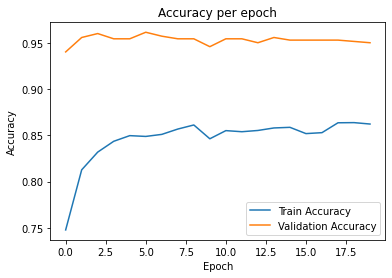

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title('Accuracy per epoch')
plt.plot(range(num_epochs), train_acc_list)
plt.plot(range(num_epochs), val_acc_list)
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.figure()
#plt.savefig("/content/gdrive/MyDrive/Enron/acc.png")

<Figure size 432x288 with 0 Axes>

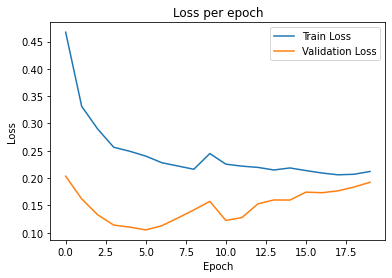

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title('Loss per epoch')
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)
plt.legend(["Train Loss", "Validation Loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.figure()
#plt.savefig("/content/gdrive/MyDrive/Enron/loss.png")

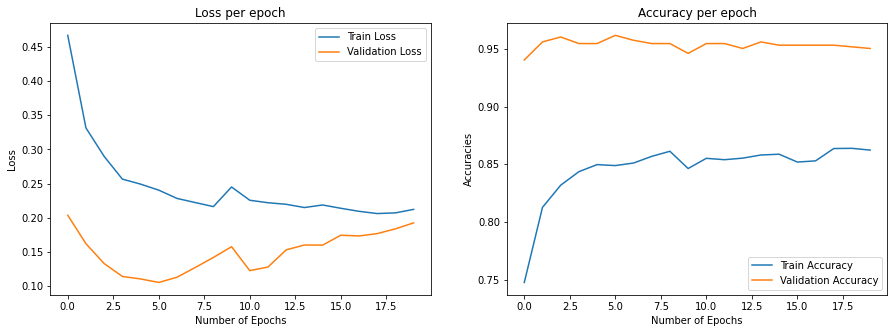

In [ ]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(121)
plt.title('Loss per epoch')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)
plt.legend(["Train Loss", "Validation Loss"])
#plt.legend(frameon=False);
plt.subplot(122)
plt.title('Accuracy per epoch')
plt.plot(range(num_epochs), train_acc_list)
plt.plot(range(num_epochs), val_acc_list)
plt.legend(["Train Accuracy", "Validation Accuracy"])
#plt.legend(frameon=False);
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracies')
#plt.savefig("/content/gdrive/MyDrive/Enron/learn_LSTM.png")
plt.show()

In [ ]:
#torch.save(model.state_dict(), '/content/gdrive/MyDrive/Enron/LSTM_model.pth' )

Confusion Matrix :
[[387   8]
 [ 26 303]]
Accuracy: 0.953
----------------------------------------------------------------------------------------------------

Classification report : 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       395
         1.0       0.97      0.92      0.95       329

    accuracy                           0.95       724
   macro avg       0.96      0.95      0.95       724
weighted avg       0.95      0.95      0.95       724

----------------------------------------------------------------------------------------------------
F1 Score: 0.947


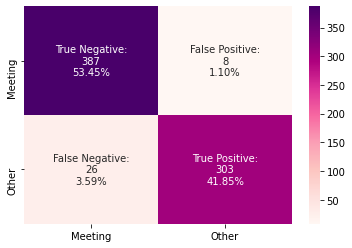

In [ ]:
if test_on:
  test_model(model, test_iterator)


In [ ]:
# random_text = 'Goodmorning guys how are you'
# processed_random_text = process_text(random_text)
# print(fields)

In [ ]:
# print(processed_random_text)
# msg = data.Example.fromlist([processed_random_text, 1],fields)
# example = data.Dataset([msg],fields)
# print(msg)
# print(example)
# #iterator = data.BucketIterator.splits(example, sort=False, batch_size= 1)

In [ ]:
# model = network(vocab_size, 
#             embedding_dim, 
#             hidden_dim, 
#             out_dim, 
#             num_layers, 
#             is_bidir, 
#             dropout, 
#             padding_index)
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/Enron/LSTM_model.pth'))


In [ ]:
# model.to(device)

In [ ]:
# vocab_obj = torch.load( '/content/gdrive/MyDrive/Enron/vocab_obj.pth')

Define and test information extractor:

In [ ]:
import spacy
myspacy = spacy.load('en')


def predict(model, input_seq):
    
    model.eval()
    with torch.no_grad():
      tokenized_sequence = [token.text for token in myspacy.tokenizer(input_seq)] 
      #print(tokenized) #tokenize the sentence 
      w2i = [message_field.vocab.stoi[t] for t in tokenized_sequence]
      #print(indexed)         
      sequence_length = [len(w2i)]                                   
      tensor = torch.LongTensor(w2i).to(device) 
      #print(tensor)             
      tensor = tensor.unsqueeze(1).T  
      #print(tensor)
      #print(tensor.shape)                        
      length_tensor = torch.LongTensor(sequence_length)  
      #print(length_tensor)              
      prediction = model(tensor, length_tensor).squeeze()
      out = torch.round(torch.sigmoid(-prediction))        
      return out.item()       

In [ ]:
sorted_months = ["january", "february", "march", "april", "may", "june","july",
          "august", "september","october","november", "december"]
sorted_days = ["monday", "tuesday", "wednesday", "thursday", "friday",
        "saturday", "sunday"]
ordinal_numbers = ["rd", "th", "st", "nd"]
numbers_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

def date_from_text(input_string):
    '''
    get datetime() date information from raw text
    '''
    
    text = input_string.lower()
    today = datetime.date.today()

    # If today is in text:
    if text.count("today") > 0:
        return today

    #if tomorrow is in text:
    if text.count("tomorrow") > 0 or text.count("tmr") > 0:
        return today + datetime.timedelta(1)

    #For the case where we have in _ days/weeks
    if bool(re.search(r'in\s(\d+|one|two|three|four|five|six|seven|eight|nine)\s(days|weeks|week)', text)):
      x = re.search(r'in\s(\d+|one|two|three|four|five|six|seven|eight|nine)\s(days|weeks|week)', text)
      match = x.group()
      n = match.split()[-2]
      if n in numbers_list:
        num = numbers_list.index(n)+1
      else:
        num = int(n)

      if match.split()[-1] == 'days':
        return today + datetime.timedelta(num)
      else:
        return today + datetime.timedelta(num*7) 

    

    day, month, day_idx = -1,-1,-1
    year = today.year

    for token in text.split():
      #regualar expression for abreviated months:
      if bool(re.search(r'jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?', token)):
        match = re.findall(r'jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?', token)[0]
        #print(match)

        #find corresponding month index
        for m in sorted_months:
          if match in m:
            month = sorted_months.index(m) + 1
            #print(month)
        
      elif bool(re.search(r'\b((mon|tues|wed(nes)?|thur(s)?|fri|sat(ur)?|sun)(day)?)\b', token)):

        match = re.findall(r'\b((mon|tues|wed(nes)?|thur(s)?|fri|sat(ur)?|sun)(day)?)\b', token)[0][0]
        
        #find corresponding day index
        for d in sorted_days:
          if match in d:
            day_idx = sorted_days.index(d)
      
      elif token in sorted_days:
        day_idx = sorted_days.index(token)

      elif token.isdigit():
        day = int(token)
        
      else:
        for ordinal in ordinal_numbers:
          found = token.find(ordinal)
          if found > 0:
            try:
              day = int(token[:found])
            except:
              pass

    #If the given month has passed go to the next year
    if month < today.month and month != -1:  
      year = year+1
    
    #If we are given the current month but day has passed
    #go to the next year 
    if month == today.month and day !=-1:
      if day < today.day:
        year = year+1

    #if month is not present:
    if month == -1 and day != -1:  
      #if day is less than current day go to next month
      if day < today.day:
        month = today.month + 1
      
      else:
        month = today.month

    
    if month == -1 and day == -1 and day_idx != -1:
      today_idx = today.weekday()
      difference = day_idx - today_idx

      if difference < 0:
        difference += 7
        if text.count("next") >= 1:
          difference += 7

      return today + datetime.timedelta(difference)

    if day != -1:  
      return datetime.datetime(month=month, day=day, year=year)
    
    else:
      matches = datefinder.find_dates(input_string)
      for match in matches:
        return match.date()
      

In [ ]:
def time_from_text(input_string):
  
  if bool(re.search(r'(([0-1]{0,1}[0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[1-9]|1[0-2])(:|\.)[0-5][0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[0-9]|1[0-9]|2[0-3])(:|\.)[0-5][0-9]))', input_string)):
    match = re.findall(r'(([0-1]{0,1}[0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[1-9]|1[0-2])(:|\.)[0-5][0-9]( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[0-9]|1[0-9]|2[0-3])(:|\.)[0-5][0-9]))', input_string)[0][0]
    match = match.lower()

    match_list = match.split()
    #print(match_list)
    
    if len(match_list) == 1:
      
      if 'pm' in match:
        
        i = match.index('pm')
        num = match[:i]
        
        if ':' in num:
          split = num.split(':')
          hours = int(split[0]) +12
          minutes = int(split[1])
      
        else:
          hours = int(num) + 12
          minutes = 0
      
      elif 'am' in match:
        i = match.index('am')
        num = match[:i]
        
        if ':' in num:
          split = num.split(':')
          hours = int(split[0])
          minutes = int(split[1])
        else:
          hours = int(num)
          minutes = 0
      
      else:
        split = match.split(':')
        hours = int(split[0])
        minutes = int(split[1])
      
    elif len(match_list) == 2:
      
      if ':' in match_list[0]:
        
        split = match_list[0].split(':')
        hours = int(split[0])
        minutes = int(split[1])
     
      else:
        hours = int(match_list[0])
        minutes = 0
      
      if match_list[-1] == 'pm':
        hours += 12

        
  else:
    
    print('No time in string')
    return None
  #print('Hours:',hours)
  #print('Minutes:', minutes)
  timeobj = datetime.time(hours, minutes)
  return timeobj

In [ ]:
random_text = 'Board meeting tomorrow at 5pm'
processed_random_text = process_text(random_text)
prediction = predict(model, processed_random_text)
if prediction == 0:
  print(100*'-')
  print('String contains meeting request. ')
  print(100*'-')
  print()
  date = date_from_text(random_text)
  time = time_from_text(random_text)
  print(100*'-')
  print('Date:', date)
  print(100*'-')
  print()
  print(100*'-')
  print('Time:', time)
  print(100*'-')

elif prediction == 1:
  print('Other')
else:
  print('Something wrong')

----------------------------------------------------------------------------------------------------
String contains meeting request. 
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Date: 2021-08-17
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Time: 17:00:00
----------------------------------------------------------------------------------------------------


In [ ]:
# pd.set_option('display.max_colwidth', None)
# test_df[test_df['target'] == 1]

In [ ]:
random_text = 'tomorrow at 6'
date = date_from_text(random_text)
time = time_from_text(random_text)
print('date:', date)
print('time:', time)

No time in string
date: 2021-08-17
time: None


In [ ]:
train_df[train_df['target'] == 0]['text']

6438    fyi details naveens demo racs processestools r...
282     altura gains co poi 78023 chris greaney date 5...
6635    calendar entry reminder mail mortgage payment ...
6155        arriving fbo signature flight support wa intl
6620    calendar entry invitation operational risk for...
                              ...                        
972     weekly priority mtgraetta date 12202001 time 9...
1007    terry k oncall date 552001 time 700 800 centra...
6492    calendar entry invitation happy hour berney ed...
1164    discuss financial reporting needs lynns office...
6743    dallas lisa left emergency numbers group forwa...
Name: text, Length: 2716, dtype: object